# Stationary SCM and DAG (STAT.) from figure 1 in paper

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../src/")
sys.path.append("..")

from src.examples.example_setups import setup_stat_scm
from src.utils.sequential_sampling import sequentially_sample_model
from src.utils.sem_utils.toy_sems import StationaryDependentSEM as StatSEM
from src.utils.plotting import plot_outcome
from src.utils.sem_utils.sem_estimate import build_sem_hat

from numpy.random import seed

# Models
from src.methods.bo import BO
from src.methods.cbo import CBO
from src.methods.abo import ABO
from src.methods.dcbo import DCBO

seed(seed=0)

## Sample SEM to get observational samples

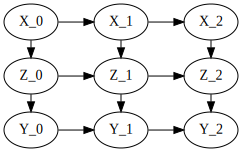

In [8]:
T = 3 # In this example, as in the paper, we consider three time-slices
init_sem, sem, dag_view, G, exploration_sets, intervention_domain, true_objective_values, all_causal_effects  = setup_stat_scm(T=T)
# This is just a snapshot of the DAG at hand
dag_view

The above DAG is the graphical structure we will be working with and is faithful to the one used in figure one in the paper. `dag` is a networkx object i.e.

In [5]:
type(G)

networkx.classes.multidigraph.MultiDiGraph

and is the one we will use for exploring the optimization methods further down. `dag_view` is simply a convenient way to visualise the structure at hand and is just a string that we visulise using `pygraphviz`:

In [14]:
print(dag_view)

digraph { rankdir=LR; X_0 -> Z_0; Z_0 -> Y_0; X_1 -> Z_1; Z_1 -> Y_1; X_2 -> Z_2; Z_2 -> Y_2;  X_0 -> X_1; Z_0 -> Z_1; Y_0 -> Y_1; X_1 -> X_2; Z_1 -> Z_2; Y_1 -> Y_2;  { rank=same; X_0 Z_0 Y_0 } { rank=same; X_1 Z_1 Y_1 } { rank=same; X_2 Z_2 Y_2 }  }



Notice that we make use of two types of structural equations models: `init_sem` and `sem`. The latter concerns interactions with the first time-slice in the DBN, which has no incoming edges from the previous time-slices, and is only active at $t=0$. For all other time-slices i.e. when $t>0$ the `sem` model is used.

In [5]:
# Number of independent samples (samples here are the time-series on the horizontal) per time-index
D_O = sequentially_sample_model(init_sem,
                                sem,
                                total_timesteps=T,
                                sample_count=20, # How many samples we take per node in each time-slice
                                epsilon=None) # If we employ a noise model or not

In [6]:
# Simulate some interventional data

from src.utils.utilities import powerset, get_monte_carlo_expectation
from src.utils.sequential_intervention_functions import make_sequential_intervention_dict
from numpy import zeros

D_I = {k: None for k in powerset(["X", "Z"])}
"""
do(Z_0)
"""
interv = make_sequential_intervention_dict(G,T)
# Univariate intervention at time 0
interv["Z"][0] = 1.0
static_noise_model = {k: zeros(T) for k in ["X", "Z", "Y"]}
# Sample this model with one intervention, and no noise
intervention_samples = sequentially_sample_model(
    init_sem,
    sem,
    total_timesteps=T,
    interventions=interv,
    sample_count=1,
    epsilon=static_noise_model
)

# Note: we obvs don't need to take MC samples if noise-model is zero
D_I[("Z",)] = get_monte_carlo_expectation(intervention_samples)


The above observation samples contained in `D_obs` are sequential in the sense that the sample function generates each column per variable, conditional on the column samples at $t-1$.

## Other setup parameters 

In [9]:
# Contains the exploration sets we will be investigating
print("Exploration sets:", exploration_sets)
# The intervention domains for the manipulative variables
print("Intervention domains:", intervention_domain) 
# The true outcome values of Y given an optimal intervention on the three time-slices
print("True optimal outcome values:", [r"y^*_{} = {}".format(t,val.round(3)) for t,val in enumerate(true_objective_values)])
# Number of trials
N = 10

Exploration sets: [('X',), ('Z',), ('X', 'Z')]
Intervention domains: {'X': [-4, 1], 'Z': [-3, 3]}
True optimal outcome values: ['y^*_0 = -2.152', 'y^*_1 = -4.304', 'y^*_2 = -6.455']


## Explore optimization methods

In all these examples we do not employ any interventional data, just observational.

### Vanilla Bayesian Optimization 

In [27]:
# Setup the input parameters to be used with the Bayesian optimization
BO_input_params = {
    "G":G,
    "sem": StatSEM,
    "base_target_variable": "Y",
    "observation_samples": D_O, # Observational samples
    "intervention_domain": intervention_domain,
    "intervention_samples":None,   
    "number_of_trials": N,
    "optimal_assigned_blankets": None,
    "sample_anchor_points": True,
    "seed_anchor_points": 1,
    "change_points": None
}
# Run Bayesian optimization
bo = BO(**BO_input_params)
bo.run()

Time index: 100%|██████████| 3/3 [00:00<00:00,  4.79it/s]


In [28]:
bo.assigned_blanket

{'X': [-1.5005874958722, -3.9271251875729014, -1.0247396789687988],
 'Y': [-2.111148824950811, -4.26018454126298, -6.103437908573766],
 'Z': [-2.8506046346979117, -2.9864445988889186, 2.941345628240498]}

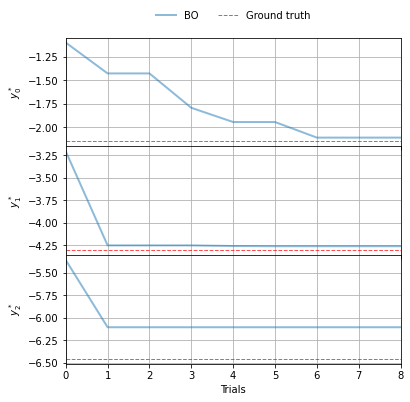

In [29]:
plot_outcome(T,N,outcomes=[bo.optimal_outcome_values_during_trials],labels=['BO'],true_objective_values=true_objective_values)

### Adaptive Bayesian Optimization
The setup for ABO is the same as for BO.

In [30]:
abo = ABO(**BO_input_params)
abo.run()

Time index: 100%|██████████| 3/3 [00:00<00:00,  4.30it/s]


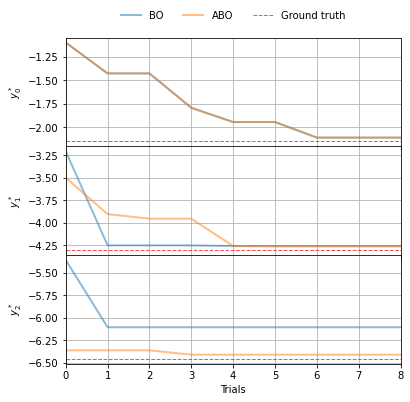

In [31]:
plot_outcome(T,N,outcomes=[bo.optimal_outcome_values_during_trials,abo.optimal_outcome_values_during_trials],labels=['BO', 'ABO'],true_objective_values=true_objective_values)

### Causal Bayesian Optimization
CBO has one extra parameter (though there are many others which we are not demonstrating in this demo) which is the SEM estimator method `build_sem_hat`. It estimates a SEM model from the observational data.

In [10]:

CBO_input_params = {
    "G": G,
    "sem": StatSEM,
    "base_target_variable": "Y",
    "make_sem_estimator": build_sem_hat,
    "exploration_sets":exploration_sets,
    "observation_samples": D_O,
    "intervention_samples":D_I, # Interventional data as well
    "intervention_domain": intervention_domain,
    "intervention_samples":None,
    "number_of_trials": N,
    "sample_anchor_points": True,
    "seed_anchor_points": 1,
    "debug_mode":True,
    "ground_truth":all_causal_effects
}

Time index:   0%|          | 0/3 [00:00<?, ?it/s]



>>>
Iteration: 1
<<<



		[0] The BO model does not exists for ES: ('X',) at t == 0.

Assigned blanket {'X': [None, None, None], 'Y': [None, None, None], 'Z': [None, None, None]}


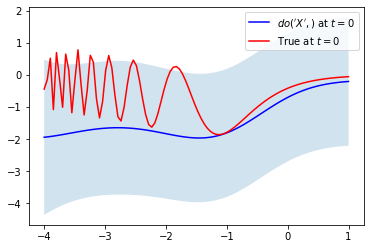


		[0] The BO model does not exists for ES: ('Z',) at t == 0.

Assigned blanket {'X': [None, None, None], 'Y': [None, None, None], 'Z': [None, None, None]}


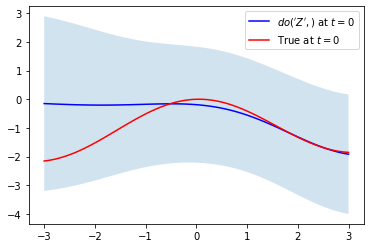

reconstraining parameters GP_regression.rbf.variance


Selected set: ('X',)
Intervention value: [[-1.42555444]]
Outcome: -1.336783371564863
>>> Results of optimization

		[1] The BO model exists for ES: ('X',) at t == 0.

Assigned blanket {'X': [None, None, None], 'Y': [None, None, None], 'Z': [None, None, None]}


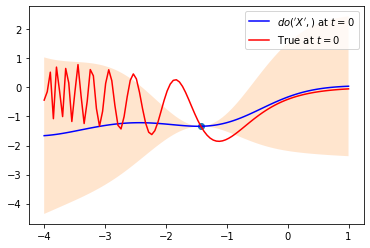


		[0] The BO model does not exists for ES: ('Z',) at t == 0.

Assigned blanket {'X': [None, None, None], 'Y': [None, None, None], 'Z': [None, None, None]}


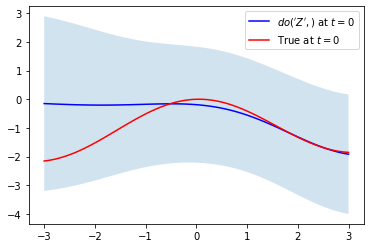

### Optimized model: ### ('X',) 
Name : GP regression
Objective : 3.378969026422559
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |    priors  
  rbf.variance             |  1.8341241897697451  |      +ve      |  Ga(2, 0.5)
  rbf.lengthscale          |                 1.0  |      +ve      |            
  Gaussian_noise.variance  |               1e-05  |   +ve fixed   |            


>>>
Iteration: 2
<<<



		[1] The BO model exists for ES: ('X',) at t == 0.

Assigned blanket {'X': [None, None, None], 'Y': [None, None, None], 'Z': [None, None, None]}


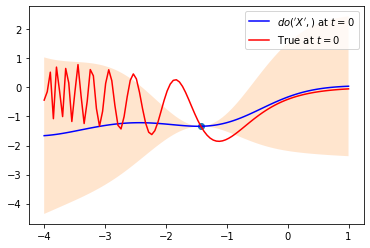


		[0] The BO model does not exists for ES: ('Z',) at t == 0.

Assigned blanket {'X': [None, None, None], 'Y': [None, None, None], 'Z': [None, None, None]}


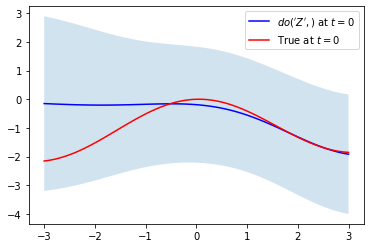

reconstraining parameters GP_regression.rbf.variance


Selected set: ('Z',)
Intervention value: [[2.96311207]]
Outcome: -1.8464115053761536
>>> Results of optimization

		[1] The BO model exists for ES: ('X',) at t == 0.

Assigned blanket {'X': [None, None, None], 'Y': [None, None, None], 'Z': [None, None, None]}


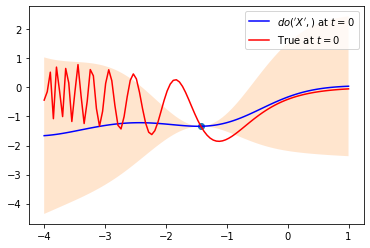


		[1] The BO model exists for ES: ('Z',) at t == 0.

Assigned blanket {'X': [None, None, None], 'Y': [None, None, None], 'Z': [None, None, None]}


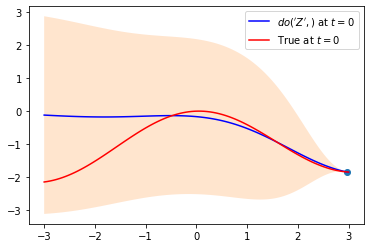

### Optimized model: ### ('Z',) 
Name : GP regression
Objective : 3.3331852523510017
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |    priors  
  rbf.variance             |  1.7413712259491225  |      +ve      |  Ga(2, 0.5)
  rbf.lengthscale          |                 1.0  |      +ve      |            
  Gaussian_noise.variance  |               1e-05  |   +ve fixed   |            


>>>
Iteration: 3
<<<



		[1] The BO model exists for ES: ('X',) at t == 0.

Assigned blanket {'X': [None, None, None], 'Y': [None, None, None], 'Z': [None, None, None]}


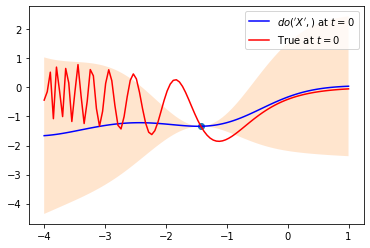


		[1] The BO model exists for ES: ('Z',) at t == 0.

Assigned blanket {'X': [None, None, None], 'Y': [None, None, None], 'Z': [None, None, None]}


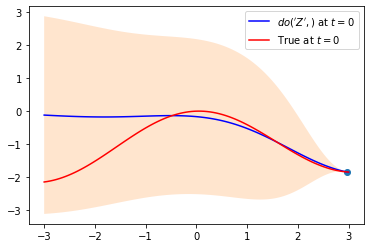

reconstraining parameters GP_regression.rbf.variance


Selected set: ('X',)
Intervention value: [[-3.88009059]]
Outcome: -0.3517500113550519
>>> Results of optimization

		[1] The BO model exists for ES: ('X',) at t == 0.

Assigned blanket {'X': [None, None, None], 'Y': [None, None, None], 'Z': [None, None, None]}


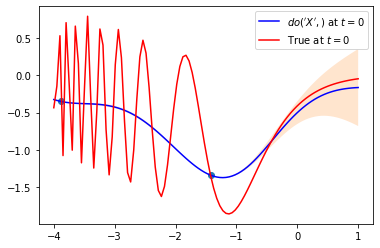


		[1] The BO model exists for ES: ('Z',) at t == 0.

Assigned blanket {'X': [None, None, None], 'Y': [None, None, None], 'Z': [None, None, None]}


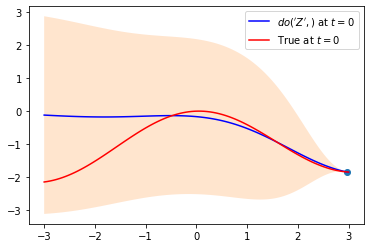

### Optimized model: ### ('X',) 
Name : GP regression
Objective : 4.787955836447233
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |    priors  
  rbf.variance             |  1.9860303314928895  |      +ve      |  Ga(2, 0.5)
  rbf.lengthscale          |  3.6749655154839425  |      +ve      |            
  Gaussian_noise.variance  |               1e-05  |   +ve fixed   |            


>>>
Iteration: 4
<<<



		[1] The BO model exists for ES: ('X',) at t == 0.

Assigned blanket {'X': [None, None, None], 'Y': [None, None, None], 'Z': [None, None, None]}


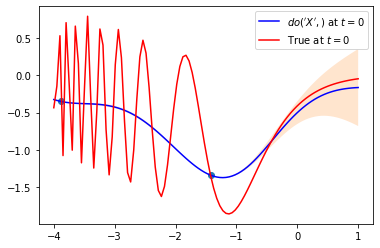


		[1] The BO model exists for ES: ('Z',) at t == 0.

Assigned blanket {'X': [None, None, None], 'Y': [None, None, None], 'Z': [None, None, None]}


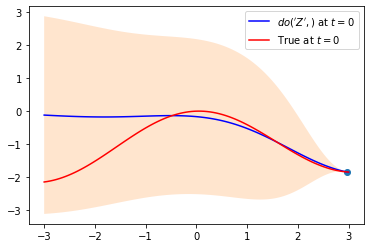

reconstraining parameters GP_regression.rbf.variance


Selected set: ('X', 'Z')
Intervention value: [[-0.42592003  2.90040406]]
Outcome: -1.836059574808286
>>> Results of optimization

		[1] The BO model exists for ES: ('X',) at t == 0.

Assigned blanket {'X': [None, None, None], 'Y': [None, None, None], 'Z': [None, None, None]}


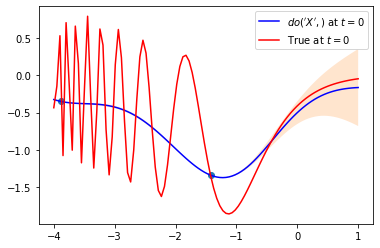


		[1] The BO model exists for ES: ('Z',) at t == 0.

Assigned blanket {'X': [None, None, None], 'Y': [None, None, None], 'Z': [None, None, None]}


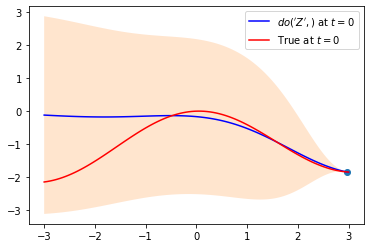

### Optimized model: ### ('X', 'Z') 
Name : GP regression
Objective : 3.332733460048665
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |    priors  
  rbf.variance             |  1.7411039647163509  |      +ve      |  Ga(2, 0.5)
  rbf.lengthscale          |                 1.0  |      +ve      |            
  Gaussian_noise.variance  |               1e-05  |   +ve fixed   |            


>>>
Iteration: 5
<<<



		[1] The BO model exists for ES: ('X',) at t == 0.

Assigned blanket {'X': [None, None, None], 'Y': [None, None, None], 'Z': [None, None, None]}


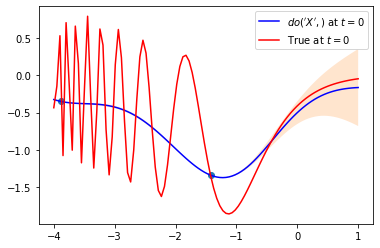


		[1] The BO model exists for ES: ('Z',) at t == 0.

Assigned blanket {'X': [None, None, None], 'Y': [None, None, None], 'Z': [None, None, None]}


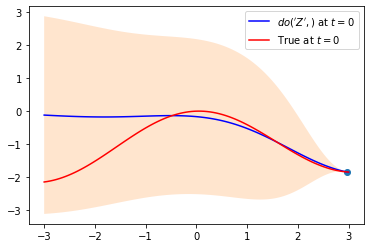

reconstraining parameters GP_regression.rbf.variance


Selected set: ('Z',)
Intervention value: [[1.89996122]]
Outcome: -1.2326275629663959
>>> Results of optimization

		[1] The BO model exists for ES: ('X',) at t == 0.

Assigned blanket {'X': [None, None, None], 'Y': [None, None, None], 'Z': [None, None, None]}


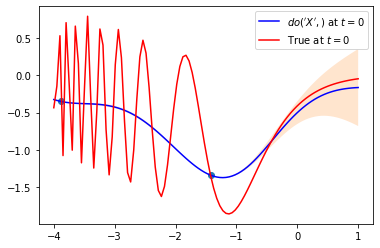


		[1] The BO model exists for ES: ('Z',) at t == 0.

Assigned blanket {'X': [None, None, None], 'Y': [None, None, None], 'Z': [None, None, None]}


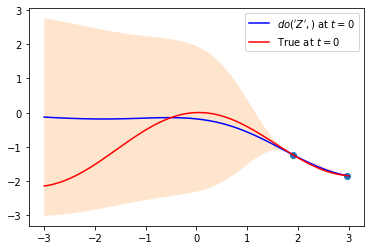

### Optimized model: ### ('Z',) 
Name : GP regression
Objective : 4.378573696460249
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |    priors  
  rbf.variance             |  1.7405543901978022  |      +ve      |  Ga(2, 0.5)
  rbf.lengthscale          |                 1.0  |      +ve      |            
  Gaussian_noise.variance  |               1e-05  |   +ve fixed   |            


>>>
Iteration: 6
<<<



		[1] The BO model exists for ES: ('X',) at t == 0.

Assigned blanket {'X': [None, None, None], 'Y': [None, None, None], 'Z': [None, None, None]}


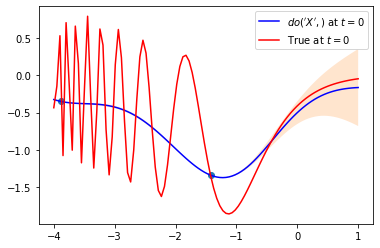


		[1] The BO model exists for ES: ('Z',) at t == 0.

Assigned blanket {'X': [None, None, None], 'Y': [None, None, None], 'Z': [None, None, None]}


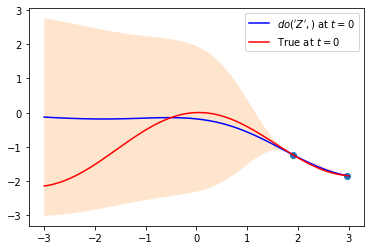

reconstraining parameters GP_regression.rbf.variance


Selected set: ('X', 'Z')
Intervention value: [[-2.32296075  2.25760593]]
Outcome: -1.5273309467244054
>>> Results of optimization

		[1] The BO model exists for ES: ('X',) at t == 0.

Assigned blanket {'X': [None, None, None], 'Y': [None, None, None], 'Z': [None, None, None]}


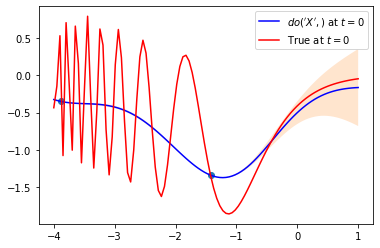


		[1] The BO model exists for ES: ('Z',) at t == 0.

Assigned blanket {'X': [None, None, None], 'Y': [None, None, None], 'Z': [None, None, None]}


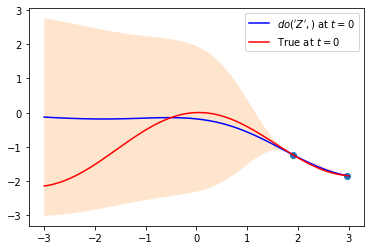

### Optimized model: ### ('X', 'Z') 
Name : GP regression
Objective : 4.643669606770976
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |    priors  
  rbf.variance             |  1.7404104947011168  |      +ve      |  Ga(2, 0.5)
  rbf.lengthscale          |                 1.0  |      +ve      |            
  Gaussian_noise.variance  |               1e-05  |   +ve fixed   |            


>>>
Iteration: 7
<<<



		[1] The BO model exists for ES: ('X',) at t == 0.

Assigned blanket {'X': [None, None, None], 'Y': [None, None, None], 'Z': [None, None, None]}


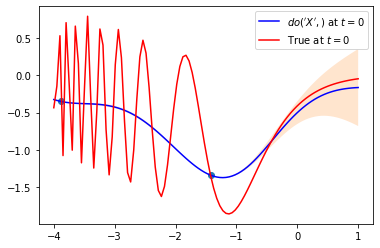


		[1] The BO model exists for ES: ('Z',) at t == 0.

Assigned blanket {'X': [None, None, None], 'Y': [None, None, None], 'Z': [None, None, None]}


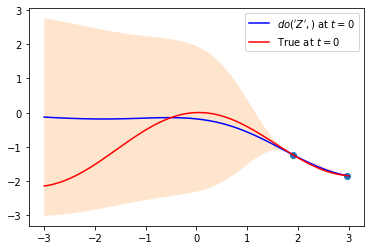

reconstraining parameters GP_regression.rbf.variance


Selected set: ('Z',)
Intervention value: [[-2.99143872]]
Outcome: -2.1500850717184137
>>> Results of optimization

		[1] The BO model exists for ES: ('X',) at t == 0.

Assigned blanket {'X': [None, None, None], 'Y': [None, None, None], 'Z': [None, None, None]}


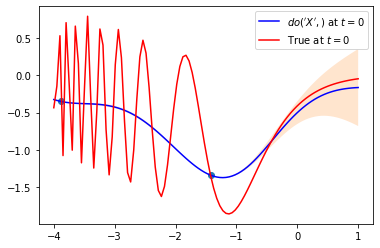


		[1] The BO model exists for ES: ('Z',) at t == 0.

Assigned blanket {'X': [None, None, None], 'Y': [None, None, None], 'Z': [None, None, None]}


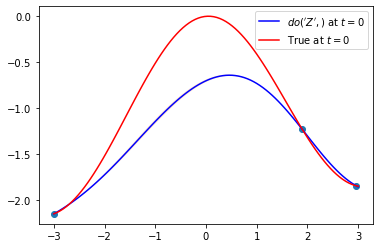

### Optimized model: ### ('Z',) 
Name : GP regression
Objective : 5.4515981099243636
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |    priors  
  rbf.variance             |  1.9759922756187924  |      +ve      |  Ga(2, 0.5)
  rbf.lengthscale          |   4.396967171482501  |      +ve      |            
  Gaussian_noise.variance  |               1e-05  |   +ve fixed   |            


>>>
Iteration: 8
<<<



		[1] The BO model exists for ES: ('X',) at t == 0.

Assigned blanket {'X': [None, None, None], 'Y': [None, None, None], 'Z': [None, None, None]}


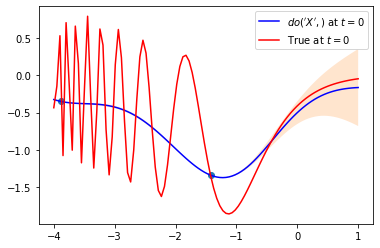


		[1] The BO model exists for ES: ('Z',) at t == 0.

Assigned blanket {'X': [None, None, None], 'Y': [None, None, None], 'Z': [None, None, None]}


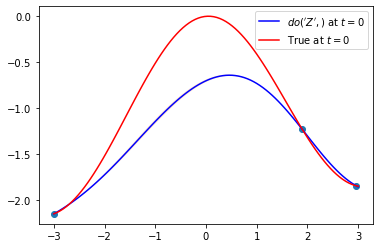

reconstraining parameters GP_regression.rbf.variance


Selected set: ('X', 'Z')
Intervention value: [[-1.9882432   2.84313145]]
Outcome: -1.8232755241013634
>>> Results of optimization

		[1] The BO model exists for ES: ('X',) at t == 0.

Assigned blanket {'X': [None, None, None], 'Y': [None, None, None], 'Z': [None, None, None]}


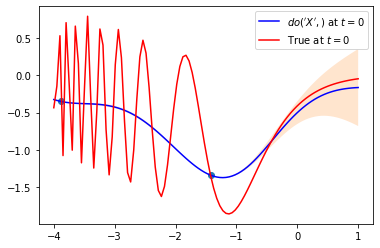


		[1] The BO model exists for ES: ('Z',) at t == 0.

Assigned blanket {'X': [None, None, None], 'Y': [None, None, None], 'Z': [None, None, None]}


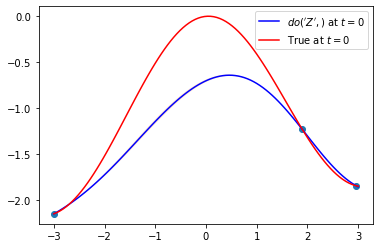

### Optimized model: ### ('X', 'Z') 
Name : GP regression
Objective : 5.339366817859135
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |    priors  
  rbf.variance             |  1.8594857863273633  |      +ve      |  Ga(2, 0.5)
  rbf.lengthscale          |                 1.0  |      +ve      |            
  Gaussian_noise.variance  |               1e-05  |   +ve fixed   |            


>>>
Iteration: 9
<<<



		[1] The BO model exists for ES: ('X',) at t == 0.

Assigned blanket {'X': [None, None, None], 'Y': [None, None, None], 'Z': [None, None, None]}


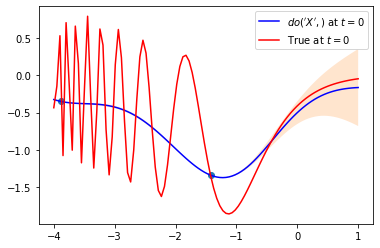


		[1] The BO model exists for ES: ('Z',) at t == 0.

Assigned blanket {'X': [None, None, None], 'Y': [None, None, None], 'Z': [None, None, None]}


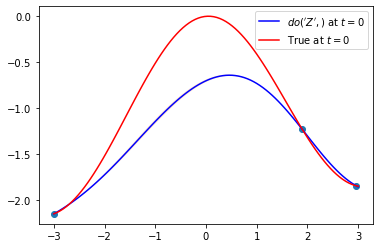

reconstraining parameters GP_regression.rbf.variance


Selected set: ('X', 'Z')
Intervention value: [[-3.33085236 -2.76750975]]
Outcome: -2.0792498173469047
>>> Results of optimization

		[1] The BO model exists for ES: ('X',) at t == 0.

Assigned blanket {'X': [None, None, None], 'Y': [None, None, None], 'Z': [None, None, None]}


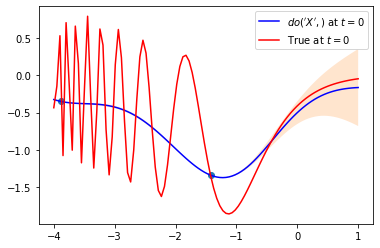


		[1] The BO model exists for ES: ('Z',) at t == 0.

Assigned blanket {'X': [None, None, None], 'Y': [None, None, None], 'Z': [None, None, None]}


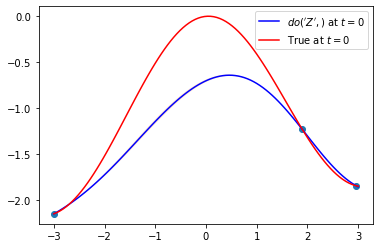

Time index:  33%|███▎      | 1/3 [00:11<00:23, 11.79s/it]

### Optimized model: ### ('X', 'Z') 
Name : GP regression
Objective : 4.682350175353181
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |    priors  
  rbf.variance             |  1.8557109965755618  |      +ve      |  Ga(2, 0.5)
  rbf.lengthscale          |  5.6679399967552575  |      +ve      |            
  Gaussian_noise.variance  |               1e-05  |   +ve fixed   |            


>>>
Iteration: 1
<<<



		[0] The BO model does not exists for ES: ('X',) at t == 1.

Assigned blanket {'X': [None, None, None], 'Y': [-2.1500850717184137, None, None], 'Z': [-2.991438716623451, None, None]}


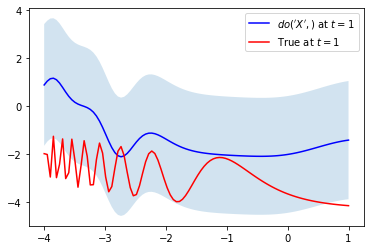


		[0] The BO model does not exists for ES: ('Z',) at t == 1.

Assigned blanket {'X': [None, None, None], 'Y': [-2.1500850717184137, None, None], 'Z': [-2.991438716623451, None, None]}


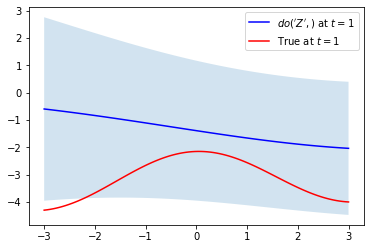

reconstraining parameters GP_regression.rbf.variance


Selected set: ('X',)
Intervention value: [[-2.76411381]]
Outcome: -1.7222477250304933
>>> Results of optimization

		[1] The BO model exists for ES: ('X',) at t == 1.

Assigned blanket {'X': [None, None, None], 'Y': [-2.1500850717184137, None, None], 'Z': [-2.991438716623451, None, None]}


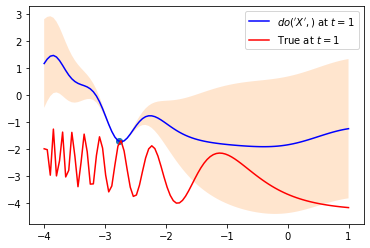


		[0] The BO model does not exists for ES: ('Z',) at t == 1.

Assigned blanket {'X': [None, None, None], 'Y': [-2.1500850717184137, None, None], 'Z': [-2.991438716623451, None, None]}


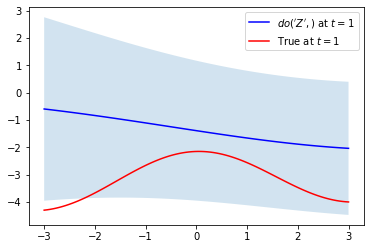

### Optimized model: ### ('X',) 
Name : GP regression
Objective : 3.4170658371409335
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |              value  |  constraints  |    priors  
  rbf.variance             |  1.771953801595735  |      +ve      |  Ga(2, 0.5)
  rbf.lengthscale          |                1.0  |      +ve      |            
  Gaussian_noise.variance  |              1e-05  |   +ve fixed   |            


>>>
Iteration: 2
<<<



		[1] The BO model exists for ES: ('X',) at t == 1.

Assigned blanket {'X': [None, None, None], 'Y': [-2.1500850717184137, None, None], 'Z': [-2.991438716623451, None, None]}


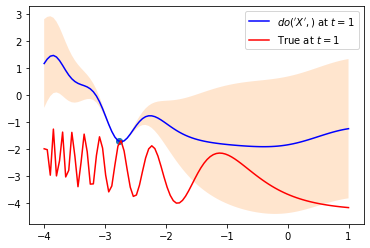


		[0] The BO model does not exists for ES: ('Z',) at t == 1.

Assigned blanket {'X': [None, None, None], 'Y': [-2.1500850717184137, None, None], 'Z': [-2.991438716623451, None, None]}


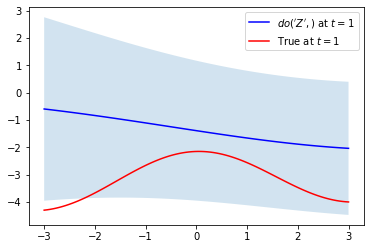

reconstraining parameters GP_regression.rbf.variance


Selected set: ('Z',)
Intervention value: [[2.90040406]]
Outcome: -3.9861446465266996
>>> Results of optimization

		[1] The BO model exists for ES: ('X',) at t == 1.

Assigned blanket {'X': [None, None, None], 'Y': [-2.1500850717184137, None, None], 'Z': [-2.991438716623451, None, None]}


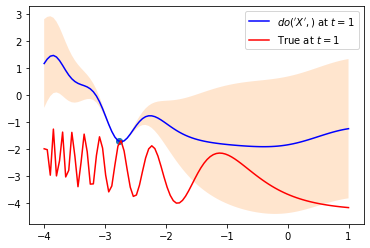


		[1] The BO model exists for ES: ('Z',) at t == 1.

Assigned blanket {'X': [None, None, None], 'Y': [-2.1500850717184137, None, None], 'Z': [-2.991438716623451, None, None]}


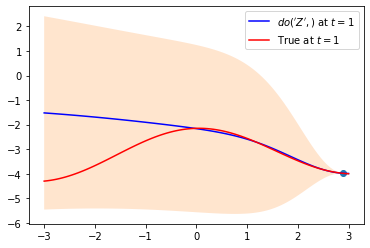

### Optimized model: ### ('Z',) 
Name : GP regression
Objective : 3.8974512027202164
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |    priors  
  rbf.variance             |  2.4506067438115795  |      +ve      |  Ga(2, 0.5)
  rbf.lengthscale          |                 1.0  |      +ve      |            
  Gaussian_noise.variance  |               1e-05  |   +ve fixed   |            


>>>
Iteration: 3
<<<



		[1] The BO model exists for ES: ('X',) at t == 1.

Assigned blanket {'X': [None, None, None], 'Y': [-2.1500850717184137, None, None], 'Z': [-2.991438716623451, None, None]}


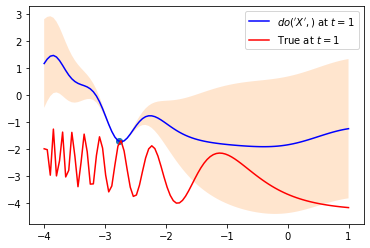


		[1] The BO model exists for ES: ('Z',) at t == 1.

Assigned blanket {'X': [None, None, None], 'Y': [-2.1500850717184137, None, None], 'Z': [-2.991438716623451, None, None]}


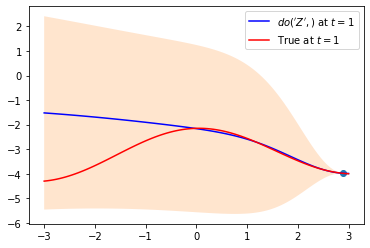

reconstraining parameters GP_regression.rbf.variance


Selected set: ('Z',)
Intervention value: [[1.81302337]]
Outcome: -3.303286578524359
>>> Results of optimization

		[1] The BO model exists for ES: ('X',) at t == 1.

Assigned blanket {'X': [None, None, None], 'Y': [-2.1500850717184137, None, None], 'Z': [-2.991438716623451, None, None]}


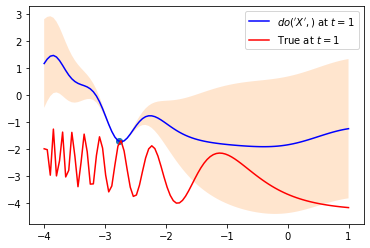


		[1] The BO model exists for ES: ('Z',) at t == 1.

Assigned blanket {'X': [None, None, None], 'Y': [-2.1500850717184137, None, None], 'Z': [-2.991438716623451, None, None]}


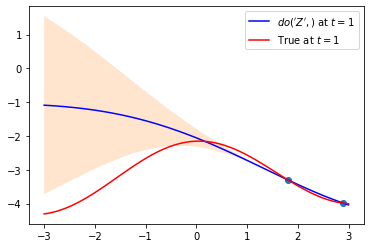

### Optimized model: ### ('Z',) 
Name : GP regression
Objective : 4.506120894221821
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |    priors  
  rbf.variance             |  2.3023986477649845  |      +ve      |  Ga(2, 0.5)
  rbf.lengthscale          |   3.233377040535972  |      +ve      |            
  Gaussian_noise.variance  |               1e-05  |   +ve fixed   |            


>>>
Iteration: 4
<<<



		[1] The BO model exists for ES: ('X',) at t == 1.

Assigned blanket {'X': [None, None, None], 'Y': [-2.1500850717184137, None, None], 'Z': [-2.991438716623451, None, None]}


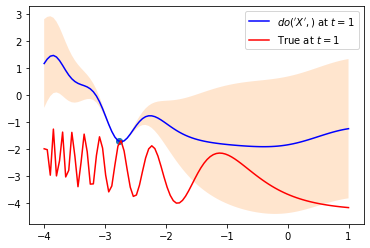


		[1] The BO model exists for ES: ('Z',) at t == 1.

Assigned blanket {'X': [None, None, None], 'Y': [-2.1500850717184137, None, None], 'Z': [-2.991438716623451, None, None]}


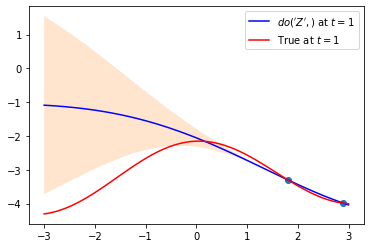

reconstraining parameters GP_regression.rbf.variance


Selected set: ('X',)
Intervention value: [[-0.19552212]]
Outcome: -3.446189629857402
>>> Results of optimization

		[1] The BO model exists for ES: ('X',) at t == 1.

Assigned blanket {'X': [None, None, None], 'Y': [-2.1500850717184137, None, None], 'Z': [-2.991438716623451, None, None]}


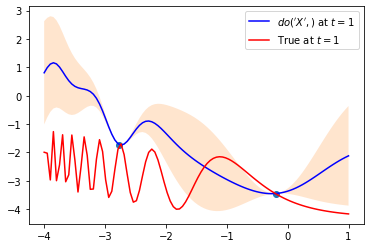


		[1] The BO model exists for ES: ('Z',) at t == 1.

Assigned blanket {'X': [None, None, None], 'Y': [-2.1500850717184137, None, None], 'Z': [-2.991438716623451, None, None]}


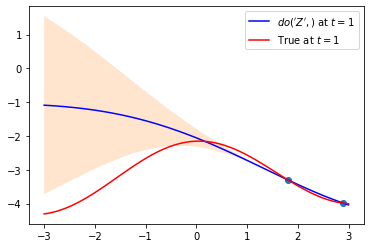

### Optimized model: ### ('X',) 
Name : GP regression
Objective : 5.271217823606995
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |    priors  
  rbf.variance             |  1.7601256742837543  |      +ve      |  Ga(2, 0.5)
  rbf.lengthscale          |  0.8416628293513181  |      +ve      |            
  Gaussian_noise.variance  |               1e-05  |   +ve fixed   |            


>>>
Iteration: 5
<<<



		[1] The BO model exists for ES: ('X',) at t == 1.

Assigned blanket {'X': [None, None, None], 'Y': [-2.1500850717184137, None, None], 'Z': [-2.991438716623451, None, None]}


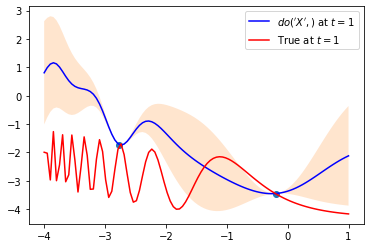


		[1] The BO model exists for ES: ('Z',) at t == 1.

Assigned blanket {'X': [None, None, None], 'Y': [-2.1500850717184137, None, None], 'Z': [-2.991438716623451, None, None]}


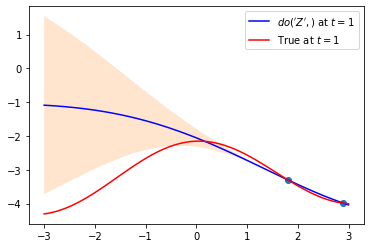

reconstraining parameters GP_regression.rbf.variance


Selected set: ('X',)
Intervention value: [[-1.01314176]]
Outcome: -2.1900154100013767
>>> Results of optimization

		[1] The BO model exists for ES: ('X',) at t == 1.

Assigned blanket {'X': [None, None, None], 'Y': [-2.1500850717184137, None, None], 'Z': [-2.991438716623451, None, None]}


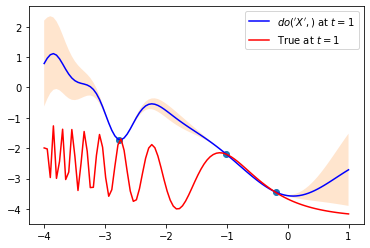


		[1] The BO model exists for ES: ('Z',) at t == 1.

Assigned blanket {'X': [None, None, None], 'Y': [-2.1500850717184137, None, None], 'Z': [-2.991438716623451, None, None]}


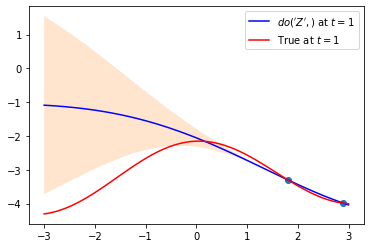

### Optimized model: ### ('X',) 
Name : GP regression
Objective : 6.47070225254574
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |    priors  
  rbf.variance             |  1.7024557296702658  |      +ve      |  Ga(2, 0.5)
  rbf.lengthscale          |  1.0510304672046185  |      +ve      |            
  Gaussian_noise.variance  |               1e-05  |   +ve fixed   |            


>>>
Iteration: 6
<<<



		[1] The BO model exists for ES: ('X',) at t == 1.

Assigned blanket {'X': [None, None, None], 'Y': [-2.1500850717184137, None, None], 'Z': [-2.991438716623451, None, None]}


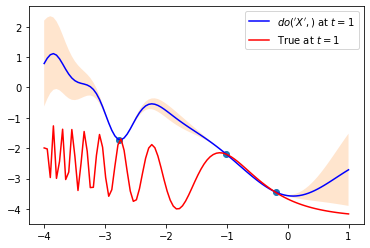


		[1] The BO model exists for ES: ('Z',) at t == 1.

Assigned blanket {'X': [None, None, None], 'Y': [-2.1500850717184137, None, None], 'Z': [-2.991438716623451, None, None]}


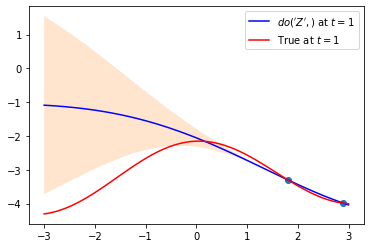

reconstraining parameters GP_regression.rbf.variance


Selected set: ('X',)
Intervention value: [[0.8902904]]
Outcome: -4.13471466730725
>>> Results of optimization

		[1] The BO model exists for ES: ('X',) at t == 1.

Assigned blanket {'X': [None, None, None], 'Y': [-2.1500850717184137, None, None], 'Z': [-2.991438716623451, None, None]}


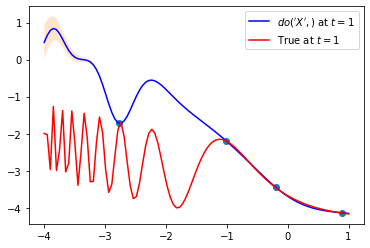


		[1] The BO model exists for ES: ('Z',) at t == 1.

Assigned blanket {'X': [None, None, None], 'Y': [-2.1500850717184137, None, None], 'Z': [-2.991438716623451, None, None]}


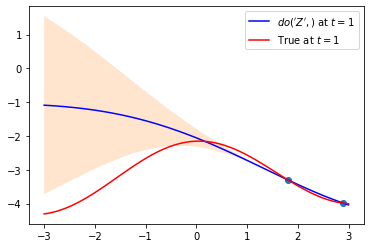

### Optimized model: ### ('X',) 
Name : GP regression
Objective : 7.071368247556413
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |    priors  
  rbf.variance             |  2.4603869749987384  |      +ve      |  Ga(2, 0.5)
  rbf.lengthscale          |  1.8483635796050937  |      +ve      |            
  Gaussian_noise.variance  |               1e-05  |   +ve fixed   |            


>>>
Iteration: 7
<<<



		[1] The BO model exists for ES: ('X',) at t == 1.

Assigned blanket {'X': [None, None, None], 'Y': [-2.1500850717184137, None, None], 'Z': [-2.991438716623451, None, None]}


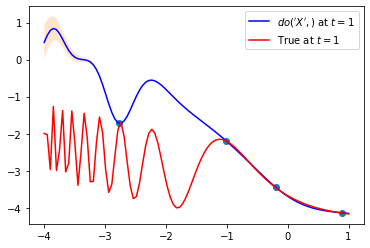


		[1] The BO model exists for ES: ('Z',) at t == 1.

Assigned blanket {'X': [None, None, None], 'Y': [-2.1500850717184137, None, None], 'Z': [-2.991438716623451, None, None]}


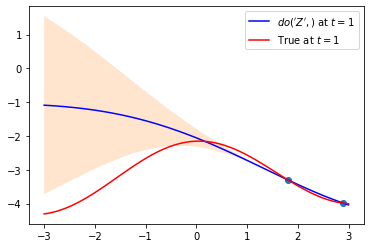

reconstraining parameters GP_regression.rbf.variance


Selected set: ('X', 'Z')
Intervention value: [[-1.43441644  2.59534556]]
Outcome: -3.8828649873526664
>>> Results of optimization

		[1] The BO model exists for ES: ('X',) at t == 1.

Assigned blanket {'X': [None, None, None], 'Y': [-2.1500850717184137, None, None], 'Z': [-2.991438716623451, None, None]}


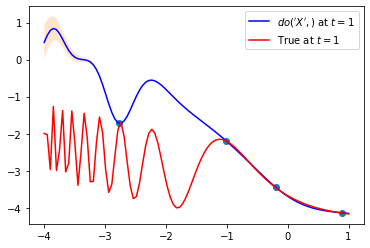


		[1] The BO model exists for ES: ('Z',) at t == 1.

Assigned blanket {'X': [None, None, None], 'Y': [-2.1500850717184137, None, None], 'Z': [-2.991438716623451, None, None]}


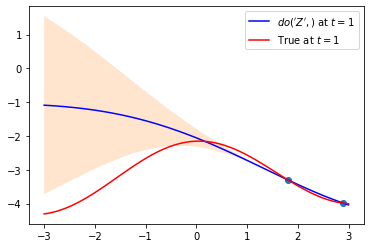

### Optimized model: ### ('X', 'Z') 
Name : GP regression
Objective : 3.86630927435774
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |    priors  
  rbf.variance             |  2.4115754818151216  |      +ve      |  Ga(2, 0.5)
  rbf.lengthscale          |                 1.0  |      +ve      |            
  Gaussian_noise.variance  |               1e-05  |   +ve fixed   |            


>>>
Iteration: 8
<<<



		[1] The BO model exists for ES: ('X',) at t == 1.

Assigned blanket {'X': [None, None, None], 'Y': [-2.1500850717184137, None, None], 'Z': [-2.991438716623451, None, None]}


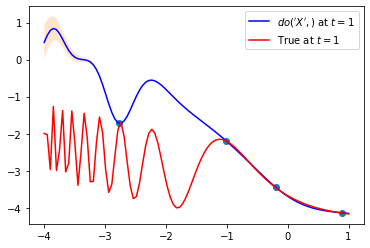


		[1] The BO model exists for ES: ('Z',) at t == 1.

Assigned blanket {'X': [None, None, None], 'Y': [-2.1500850717184137, None, None], 'Z': [-2.991438716623451, None, None]}


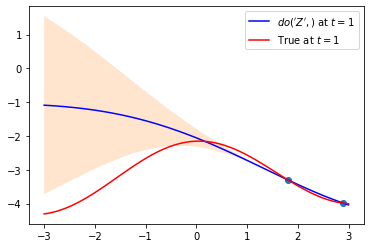

reconstraining parameters GP_regression.rbf.variance


Selected set: ('X', 'Z')
Intervention value: [[-1.24649272  1.33584307]]
Outcome: -2.852677140475965
>>> Results of optimization

		[1] The BO model exists for ES: ('X',) at t == 1.

Assigned blanket {'X': [None, None, None], 'Y': [-2.1500850717184137, None, None], 'Z': [-2.991438716623451, None, None]}


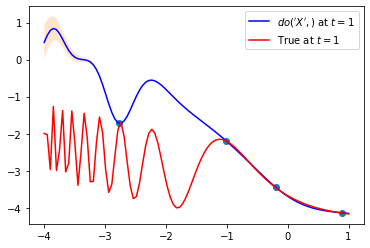


		[1] The BO model exists for ES: ('Z',) at t == 1.

Assigned blanket {'X': [None, None, None], 'Y': [-2.1500850717184137, None, None], 'Z': [-2.991438716623451, None, None]}


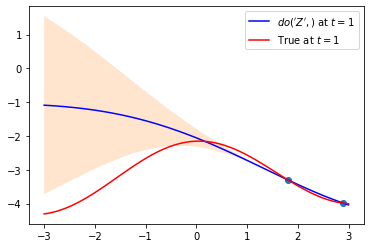

### Optimized model: ### ('X', 'Z') 
Name : GP regression
Objective : 4.865011169841029
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |    priors  
  rbf.variance             |  2.1890755245152653  |      +ve      |  Ga(2, 0.5)
  rbf.lengthscale          |  2.2812991248767944  |      +ve      |            
  Gaussian_noise.variance  |               1e-05  |   +ve fixed   |            


>>>
Iteration: 9
<<<



		[1] The BO model exists for ES: ('X',) at t == 1.

Assigned blanket {'X': [None, None, None], 'Y': [-2.1500850717184137, None, None], 'Z': [-2.991438716623451, None, None]}


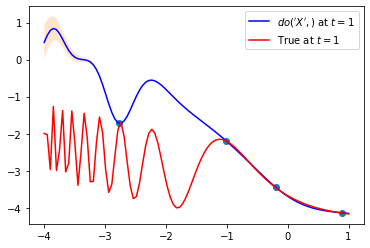


		[1] The BO model exists for ES: ('Z',) at t == 1.

Assigned blanket {'X': [None, None, None], 'Y': [-2.1500850717184137, None, None], 'Z': [-2.991438716623451, None, None]}


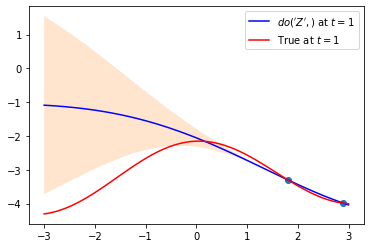

reconstraining parameters GP_regression.rbf.variance


Selected set: ('X', 'Z')
Intervention value: [[0.93947724 2.16975634]]
Outcome: -3.6110587238739353
>>> Results of optimization

		[1] The BO model exists for ES: ('X',) at t == 1.

Assigned blanket {'X': [None, None, None], 'Y': [-2.1500850717184137, None, None], 'Z': [-2.991438716623451, None, None]}


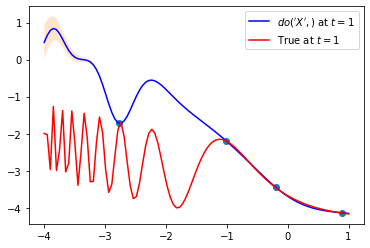


		[1] The BO model exists for ES: ('Z',) at t == 1.

Assigned blanket {'X': [None, None, None], 'Y': [-2.1500850717184137, None, None], 'Z': [-2.991438716623451, None, None]}


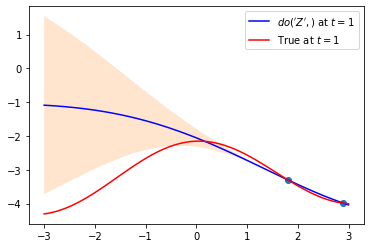

Time index:  67%|██████▋   | 2/3 [00:27<00:13, 13.98s/it]

### Optimized model: ### ('X', 'Z') 
Name : GP regression
Objective : 5.971986058146982
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |    priors  
  rbf.variance             |  2.2071500392701635  |      +ve      |  Ga(2, 0.5)
  rbf.lengthscale          |  3.1512107128504567  |      +ve      |            
  Gaussian_noise.variance  |               1e-05  |   +ve fixed   |            


>>>
Iteration: 1
<<<



		[0] The BO model does not exists for ES: ('X',) at t == 2.

Assigned blanket {'X': [None, 0.8902903950825944, None], 'Y': [-2.1500850717184137, -4.13471466730725, None], 'Z': [-2.991438716623451, -4.944370803748875, None]}


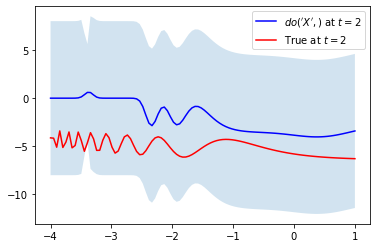


		[0] The BO model does not exists for ES: ('Z',) at t == 2.

Assigned blanket {'X': [None, 0.8902903950825944, None], 'Y': [-2.1500850717184137, -4.13471466730725, None], 'Z': [-2.991438716623451, -4.944370803748875, None]}


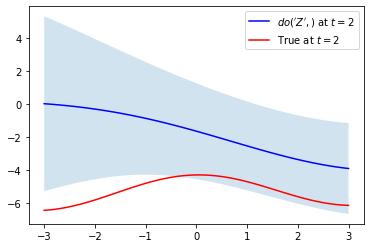

reconstraining parameters GP_regression.rbf.variance


Selected set: ('X',)
Intervention value: [[0.30266956]]
Outcome: -5.8541693657900105
>>> Results of optimization

		[1] The BO model exists for ES: ('X',) at t == 2.

Assigned blanket {'X': [None, 0.8902903950825944, None], 'Y': [-2.1500850717184137, -4.13471466730725, None], 'Z': [-2.991438716623451, -4.944370803748875, None]}


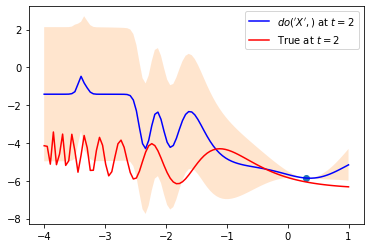


		[0] The BO model does not exists for ES: ('Z',) at t == 2.

Assigned blanket {'X': [None, 0.8902903950825944, None], 'Y': [-2.1500850717184137, -4.13471466730725, None], 'Z': [-2.991438716623451, -4.944370803748875, None]}


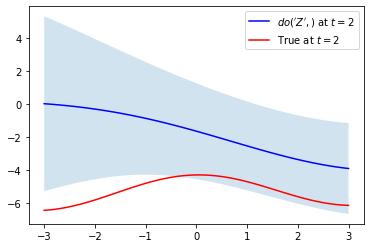

### Optimized model: ### ('X',) 
Name : GP regression
Objective : 4.042101746509404
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |    priors  
  rbf.variance             |  1.9945796769324284  |      +ve      |  Ga(2, 0.5)
  rbf.lengthscale          |                 1.0  |      +ve      |            
  Gaussian_noise.variance  |               1e-05  |   +ve fixed   |            


>>>
Iteration: 2
<<<



		[1] The BO model exists for ES: ('X',) at t == 2.

Assigned blanket {'X': [None, 0.8902903950825944, None], 'Y': [-2.1500850717184137, -4.13471466730725, None], 'Z': [-2.991438716623451, -4.944370803748875, None]}


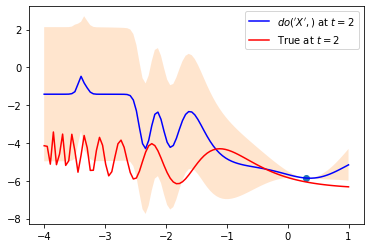


		[0] The BO model does not exists for ES: ('Z',) at t == 2.

Assigned blanket {'X': [None, 0.8902903950825944, None], 'Y': [-2.1500850717184137, -4.13471466730725, None], 'Z': [-2.991438716623451, -4.944370803748875, None]}


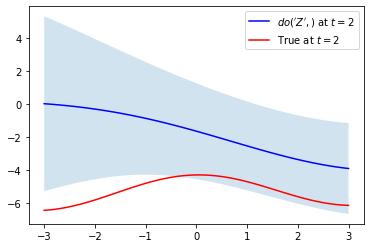

reconstraining parameters GP_regression.rbf.variance


Selected set: ('X',)
Intervention value: [[-0.77322452]]
Outcome: -6.218195770305737
>>> Results of optimization

		[1] The BO model exists for ES: ('X',) at t == 2.

Assigned blanket {'X': [None, 0.8902903950825944, None], 'Y': [-2.1500850717184137, -4.13471466730725, None], 'Z': [-2.991438716623451, -4.944370803748875, None]}


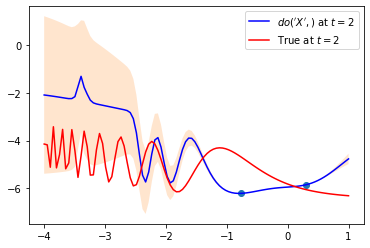


		[0] The BO model does not exists for ES: ('Z',) at t == 2.

Assigned blanket {'X': [None, 0.8902903950825944, None], 'Y': [-2.1500850717184137, -4.13471466730725, None], 'Z': [-2.991438716623451, -4.944370803748875, None]}


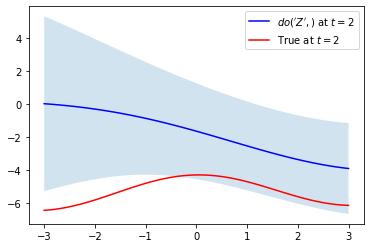

### Optimized model: ### ('X',) 
Name : GP regression
Objective : 5.459129531361086
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |    priors  
  rbf.variance             |  2.1395922184474894  |      +ve      |  Ga(2, 0.5)
  rbf.lengthscale          |   1.615653991168167  |      +ve      |            
  Gaussian_noise.variance  |               1e-05  |   +ve fixed   |            


>>>
Iteration: 3
<<<



		[1] The BO model exists for ES: ('X',) at t == 2.

Assigned blanket {'X': [None, 0.8902903950825944, None], 'Y': [-2.1500850717184137, -4.13471466730725, None], 'Z': [-2.991438716623451, -4.944370803748875, None]}


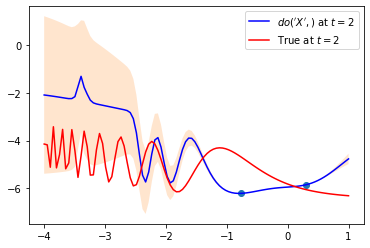


		[0] The BO model does not exists for ES: ('Z',) at t == 2.

Assigned blanket {'X': [None, 0.8902903950825944, None], 'Y': [-2.1500850717184137, -4.13471466730725, None], 'Z': [-2.991438716623451, -4.944370803748875, None]}


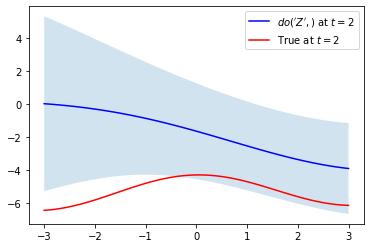

reconstraining parameters GP_regression.rbf.variance


Selected set: ('X',)
Intervention value: [[-1.92040666]]
Outcome: -5.3487189009091125
>>> Results of optimization

		[1] The BO model exists for ES: ('X',) at t == 2.

Assigned blanket {'X': [None, 0.8902903950825944, None], 'Y': [-2.1500850717184137, -4.13471466730725, None], 'Z': [-2.991438716623451, -4.944370803748875, None]}


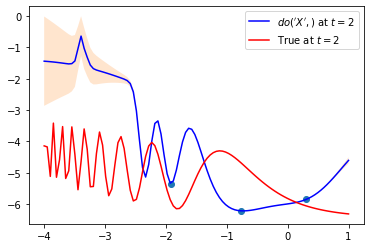


		[0] The BO model does not exists for ES: ('Z',) at t == 2.

Assigned blanket {'X': [None, 0.8902903950825944, None], 'Y': [-2.1500850717184137, -4.13471466730725, None], 'Z': [-2.991438716623451, -4.944370803748875, None]}


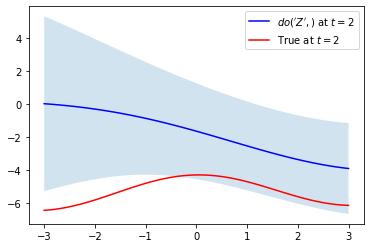

### Optimized model: ### ('X',) 
Name : GP regression
Objective : 6.358879218849449
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |    priors  
  rbf.variance             |  1.8049543489502944  |      +ve      |  Ga(2, 0.5)
  rbf.lengthscale          |  1.6035869040611643  |      +ve      |            
  Gaussian_noise.variance  |               1e-05  |   +ve fixed   |            


>>>
Iteration: 4
<<<



		[1] The BO model exists for ES: ('X',) at t == 2.

Assigned blanket {'X': [None, 0.8902903950825944, None], 'Y': [-2.1500850717184137, -4.13471466730725, None], 'Z': [-2.991438716623451, -4.944370803748875, None]}


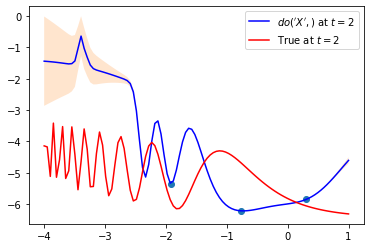


		[0] The BO model does not exists for ES: ('Z',) at t == 2.

Assigned blanket {'X': [None, 0.8902903950825944, None], 'Y': [-2.1500850717184137, -4.13471466730725, None], 'Z': [-2.991438716623451, -4.944370803748875, None]}


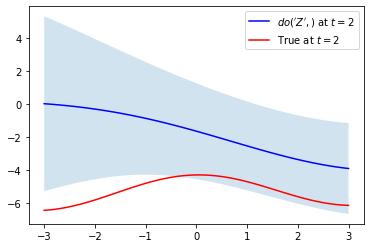

reconstraining parameters GP_regression.rbf.variance


Selected set: ('Z',)
Intervention value: [[2.97082896]]
Outcome: -5.982134223335901
>>> Results of optimization

		[1] The BO model exists for ES: ('X',) at t == 2.

Assigned blanket {'X': [None, 0.8902903950825944, None], 'Y': [-2.1500850717184137, -4.13471466730725, None], 'Z': [-2.991438716623451, -4.944370803748875, None]}


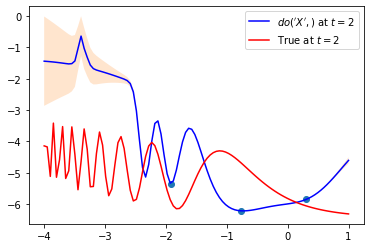


		[1] The BO model exists for ES: ('Z',) at t == 2.

Assigned blanket {'X': [None, 0.8902903950825944, None], 'Y': [-2.1500850717184137, -4.13471466730725, None], 'Z': [-2.991438716623451, -4.944370803748875, None]}


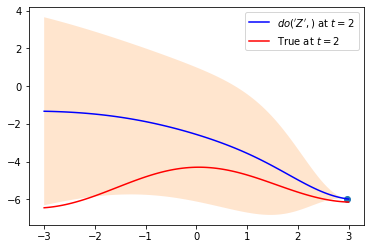

### Optimized model: ### ('Z',) 
Name : GP regression
Objective : 3.956055347983699
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |    priors  
  rbf.variance             |  2.4698702532288332  |      +ve      |  Ga(2, 0.5)
  rbf.lengthscale          |                 1.0  |      +ve      |            
  Gaussian_noise.variance  |               1e-05  |   +ve fixed   |            


>>>
Iteration: 5
<<<



		[1] The BO model exists for ES: ('X',) at t == 2.

Assigned blanket {'X': [None, 0.8902903950825944, None], 'Y': [-2.1500850717184137, -4.13471466730725, None], 'Z': [-2.991438716623451, -4.944370803748875, None]}


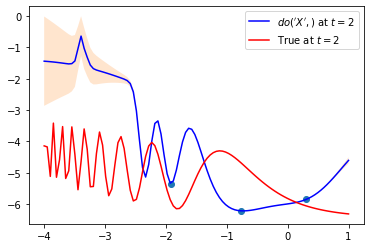


		[1] The BO model exists for ES: ('Z',) at t == 2.

Assigned blanket {'X': [None, 0.8902903950825944, None], 'Y': [-2.1500850717184137, -4.13471466730725, None], 'Z': [-2.991438716623451, -4.944370803748875, None]}


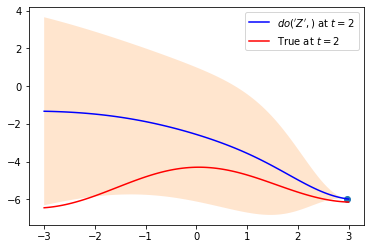

reconstraining parameters GP_regression.rbf.variance


Selected set: ('Z',)
Intervention value: [[2.09290618]]
Outcome: -5.534068588143397
>>> Results of optimization

		[1] The BO model exists for ES: ('X',) at t == 2.

Assigned blanket {'X': [None, 0.8902903950825944, None], 'Y': [-2.1500850717184137, -4.13471466730725, None], 'Z': [-2.991438716623451, -4.944370803748875, None]}


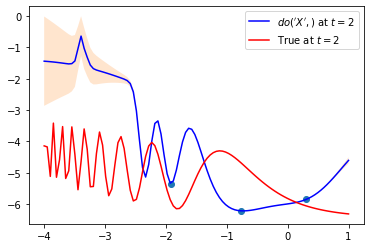


		[1] The BO model exists for ES: ('Z',) at t == 2.

Assigned blanket {'X': [None, 0.8902903950825944, None], 'Y': [-2.1500850717184137, -4.13471466730725, None], 'Z': [-2.991438716623451, -4.944370803748875, None]}


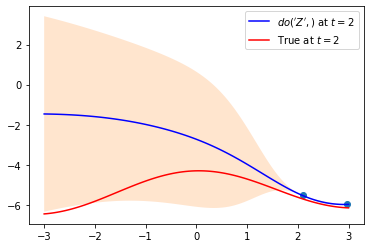

### Optimized model: ### ('Z',) 
Name : GP regression
Objective : 5.121866212007604
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |    priors  
  rbf.variance             |  2.5066743240163842  |      +ve      |  Ga(2, 0.5)
  rbf.lengthscale          |                 1.0  |      +ve      |            
  Gaussian_noise.variance  |               1e-05  |   +ve fixed   |            


>>>
Iteration: 6
<<<



		[1] The BO model exists for ES: ('X',) at t == 2.

Assigned blanket {'X': [None, 0.8902903950825944, None], 'Y': [-2.1500850717184137, -4.13471466730725, None], 'Z': [-2.991438716623451, -4.944370803748875, None]}


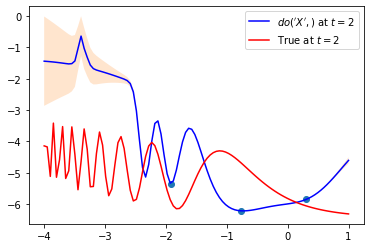


		[1] The BO model exists for ES: ('Z',) at t == 2.

Assigned blanket {'X': [None, 0.8902903950825944, None], 'Y': [-2.1500850717184137, -4.13471466730725, None], 'Z': [-2.991438716623451, -4.944370803748875, None]}


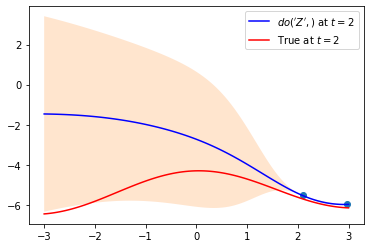

reconstraining parameters GP_regression.rbf.variance


Selected set: ('Z',)
Intervention value: [[0.7761188]]
Outcome: -4.3830142894531505
>>> Results of optimization

		[1] The BO model exists for ES: ('X',) at t == 2.

Assigned blanket {'X': [None, 0.8902903950825944, None], 'Y': [-2.1500850717184137, -4.13471466730725, None], 'Z': [-2.991438716623451, -4.944370803748875, None]}


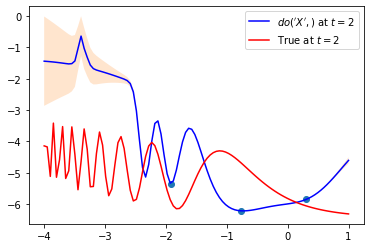


		[1] The BO model exists for ES: ('Z',) at t == 2.

Assigned blanket {'X': [None, 0.8902903950825944, None], 'Y': [-2.1500850717184137, -4.13471466730725, None], 'Z': [-2.991438716623451, -4.944370803748875, None]}


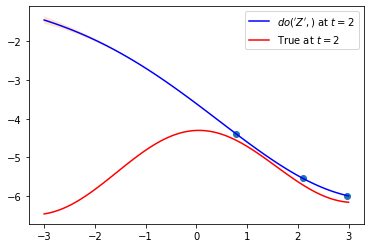

### Optimized model: ### ('Z',) 
Name : GP regression
Objective : 2.2936567417257434
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |    priors  
  rbf.variance             |  1.9691960332927758  |      +ve      |  Ga(2, 0.5)
  rbf.lengthscale          |    6.83111463187167  |      +ve      |            
  Gaussian_noise.variance  |               1e-05  |   +ve fixed   |            


>>>
Iteration: 7
<<<



		[1] The BO model exists for ES: ('X',) at t == 2.

Assigned blanket {'X': [None, 0.8902903950825944, None], 'Y': [-2.1500850717184137, -4.13471466730725, None], 'Z': [-2.991438716623451, -4.944370803748875, None]}


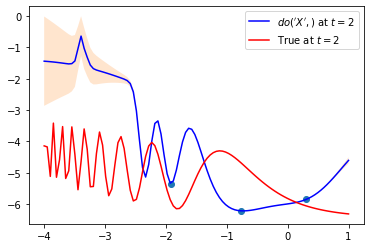


		[1] The BO model exists for ES: ('Z',) at t == 2.

Assigned blanket {'X': [None, 0.8902903950825944, None], 'Y': [-2.1500850717184137, -4.13471466730725, None], 'Z': [-2.991438716623451, -4.944370803748875, None]}


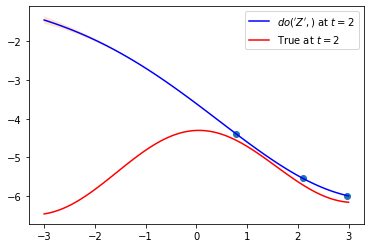

reconstraining parameters GP_regression.rbf.variance


Selected set: ('X', 'Z')
Intervention value: [[-0.68044853  2.82291075]]
Outcome: -5.95272681343088
>>> Results of optimization

		[1] The BO model exists for ES: ('X',) at t == 2.

Assigned blanket {'X': [None, 0.8902903950825944, None], 'Y': [-2.1500850717184137, -4.13471466730725, None], 'Z': [-2.991438716623451, -4.944370803748875, None]}


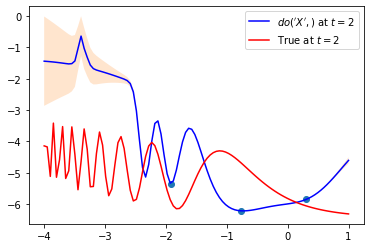


		[1] The BO model exists for ES: ('Z',) at t == 2.

Assigned blanket {'X': [None, 0.8902903950825944, None], 'Y': [-2.1500850717184137, -4.13471466730725, None], 'Z': [-2.991438716623451, -4.944370803748875, None]}


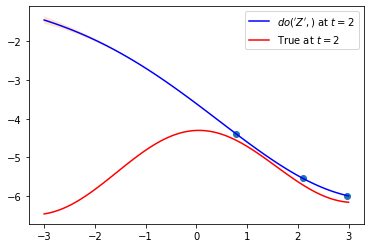

### Optimized model: ### ('X', 'Z') 
Name : GP regression
Objective : 3.970291375111091
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |              value  |  constraints  |    priors  
  rbf.variance             |  2.487829047295395  |      +ve      |  Ga(2, 0.5)
  rbf.lengthscale          |                1.0  |      +ve      |            
  Gaussian_noise.variance  |              1e-05  |   +ve fixed   |            


>>>
Iteration: 8
<<<



		[1] The BO model exists for ES: ('X',) at t == 2.

Assigned blanket {'X': [None, 0.8902903950825944, None], 'Y': [-2.1500850717184137, -4.13471466730725, None], 'Z': [-2.991438716623451, -4.944370803748875, None]}


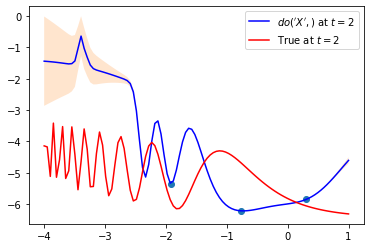


		[1] The BO model exists for ES: ('Z',) at t == 2.

Assigned blanket {'X': [None, 0.8902903950825944, None], 'Y': [-2.1500850717184137, -4.13471466730725, None], 'Z': [-2.991438716623451, -4.944370803748875, None]}


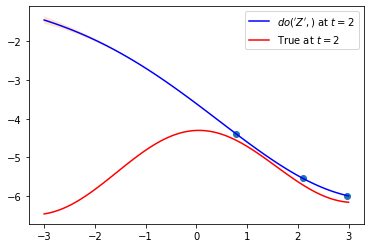

reconstraining parameters GP_regression.rbf.variance


Selected set: ('X', 'Z')
Intervention value: [[-2.08009995  2.36068562]]
Outcome: -5.733655604091101
>>> Results of optimization

		[1] The BO model exists for ES: ('X',) at t == 2.

Assigned blanket {'X': [None, 0.8902903950825944, None], 'Y': [-2.1500850717184137, -4.13471466730725, None], 'Z': [-2.991438716623451, -4.944370803748875, None]}


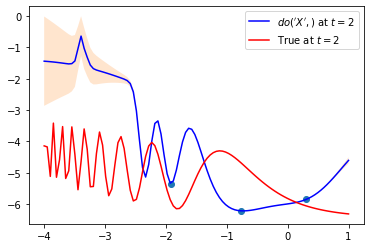


		[1] The BO model exists for ES: ('Z',) at t == 2.

Assigned blanket {'X': [None, 0.8902903950825944, None], 'Y': [-2.1500850717184137, -4.13471466730725, None], 'Z': [-2.991438716623451, -4.944370803748875, None]}


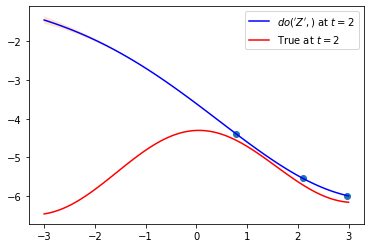

### Optimized model: ### ('X', 'Z') 
Name : GP regression
Objective : 5.5156511023484125
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |              value  |  constraints  |    priors  
  rbf.variance             |  2.511052830243579  |      +ve      |  Ga(2, 0.5)
  rbf.lengthscale          |                1.0  |      +ve      |            
  Gaussian_noise.variance  |              1e-05  |   +ve fixed   |            


>>>
Iteration: 9
<<<



		[1] The BO model exists for ES: ('X',) at t == 2.

Assigned blanket {'X': [None, 0.8902903950825944, None], 'Y': [-2.1500850717184137, -4.13471466730725, None], 'Z': [-2.991438716623451, -4.944370803748875, None]}


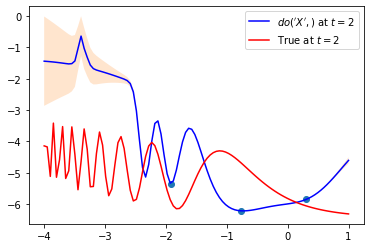


		[1] The BO model exists for ES: ('Z',) at t == 2.

Assigned blanket {'X': [None, 0.8902903950825944, None], 'Y': [-2.1500850717184137, -4.13471466730725, None], 'Z': [-2.991438716623451, -4.944370803748875, None]}


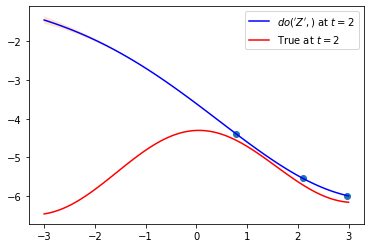

reconstraining parameters GP_regression.rbf.variance


Selected set: ('X', 'Z')
Intervention value: [[0.340016   2.22086832]]
Outcome: -5.634858279459909
>>> Results of optimization

		[1] The BO model exists for ES: ('X',) at t == 2.

Assigned blanket {'X': [None, 0.8902903950825944, None], 'Y': [-2.1500850717184137, -4.13471466730725, None], 'Z': [-2.991438716623451, -4.944370803748875, None]}


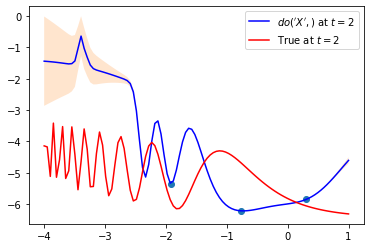


		[1] The BO model exists for ES: ('Z',) at t == 2.

Assigned blanket {'X': [None, 0.8902903950825944, None], 'Y': [-2.1500850717184137, -4.13471466730725, None], 'Z': [-2.991438716623451, -4.944370803748875, None]}


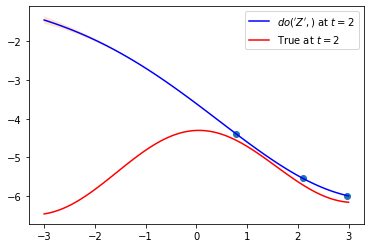

Time index: 100%|██████████| 3/3 [00:47<00:00, 15.77s/it]

### Optimized model: ### ('X', 'Z') 
Name : GP regression
Objective : 7.305349721129604
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |              value  |  constraints  |    priors  
  rbf.variance             |  3.469333968373438  |      +ve      |  Ga(2, 0.5)
  rbf.lengthscale          |                1.0  |      +ve      |            
  Gaussian_noise.variance  |              1e-05  |   +ve fixed   |            


In [11]:
cbo = CBO(**CBO_input_params)
cbo.run()

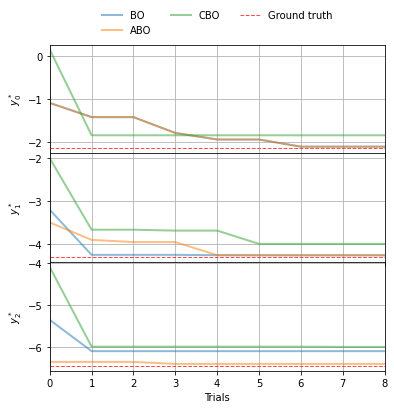

In [33]:
plot_outcome(T,N,outcomes=[bo.optimal_outcome_values_during_trials, abo.optimal_outcome_values_during_trials, cbo.optimal_outcome_values_during_trials],labels=['BO', 'ABO', 'CBO'],true_objective_values=true_objective_values)

### Dynamic Causal Bayesian Optimization

DCBO has the same input parameters as CBO. But they work very differently under the hood. DCBO takes 'horizontal' information into account i.e. is able to transfer information between time-slices. CBO has no notion of time.

In [34]:
dcbo = DCBO(**CBO_input_params)
dcbo.run()

 /Users/nd/anaconda3/envs/scibo/lib/python3.7/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
Time index:   0%|          | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
Time index:  33%|███▎      | 1/3 [00:04<00:08,  4.13s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
Time index:  67%|██████▋   | 2/3 [00:11<00:06,  6.10s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
Time index: 100%|██████████| 3/3 [00:19<00:00,  6.64s/it]


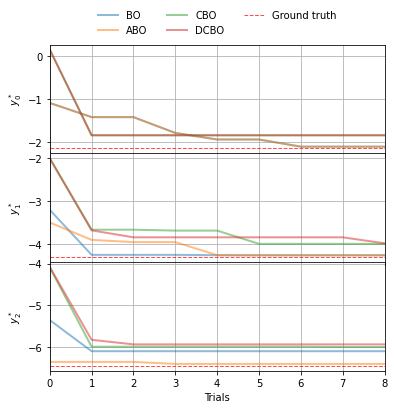

In [37]:
plot_outcome(T,N,outcomes=[bo.optimal_outcome_values_during_trials, abo.optimal_outcome_values_during_trials, cbo.optimal_outcome_values_during_trials, dcbo.optimal_outcome_values_during_trials],labels=['BO', 'ABO', 'CBO', 'DCBO'],true_objective_values=true_objective_values)